In [1]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [3]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_body_features):
    super(Emotic,self).__init__()
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_body):
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((body_features,), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [4]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_body, y_cat, y_cont, transform, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_body = x_body
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [5]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [6]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''


#train
train_body = np.load(os.path.join(data_src,'pre',saliency_method + 'train_body_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#val
val_body = np.load(os.path.join(data_src,'pre',saliency_method + 'val_body_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#test
test_body = np.load(os.path.join(data_src,'pre',saliency_method + 'test_body_arr.npy'))\

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [7]:
batch_size = 26

body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]

body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_body, train_cat, train_cont, \
                                  train_transform, body_norm)
val_dataset = Emotic_PreDataset(val_body, val_cat, val_cont, \
                                test_transform, body_norm)
test_dataset = Emotic_PreDataset(test_body, test_cat, test_cont, \
                                 test_transform, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE EMOTIC MODEL

## Resnet-18 (ImageNet)

In [ ]:
model_body = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


## Resnet-50 (ImageNet)

In [ ]:
model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

## Resnet50 (Emotic)

In [ ]:
model_body = torch.load('/content/drive/MyDrive/VA-prediction/models/body_train_lr001_b24_crossEtropy/model1.pth', map_location=lambda storage, loc: storage)

## SwinT (ImageNet)

In [8]:
model_body = models.swin_t(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 76.4MB/s]


In [9]:
batch_size = 26

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_body, train_cat, train_cont, \
                                  train_transform, body_norm)
val_dataset = Emotic_PreDataset(val_body,  val_cat, val_cont, \
                                test_transform, body_norm)
test_dataset = Emotic_PreDataset(test_body, test_cat, test_cont, \
                                 test_transform, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


## SwinT (Emotic)

In [ ]:
model_body = torch.load("/content/drive/MyDrive/VA-prediction/models/SwinT_EMOTIC.pth", map_location=lambda storage, loc: storage)

In [ ]:
batch_size = 26

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_body, train_cat, train_cont, \
                                  train_transform, body_norm)
val_dataset = Emotic_PreDataset(val_body,  val_cat, val_cont, \
                                test_transform, body_norm)
test_dataset = Emotic_PreDataset(test_body, test_cat, test_cont, \
                                 test_transform, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  447 val loader  64 test 139
completed cell


# VI. Prepare Model + Optimizer

In [10]:
emotic_model = Emotic(list(model_body.children())[-1].in_features)
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_body.parameters():
  param.requires_grad = False


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [12]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [13]:
def test_data(models, device, data_loader, num_images):
    model_body, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_body.to(device)
        emotic_model.to(device)
        model_body.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_body, labels_cat, labels_cont in iter(data_loader):
            images_body = images_body.to(device)

            pred_body = model_body(images_body)
            pred_cont = emotic_model(pred_body)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [14]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_body.to(device)

    emotic_model.train()
    model_body.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_body, labels_cat, labels_cont in iter(train_loader):
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_body = model_body(images_body)

      pred_cont = emotic_model(pred_body)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_body.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_body, labels_cat, labels_cont in iter(val_loader):
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_body = model_body(images_body)

        pred_cont = emotic_model(pred_body)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 472247.2012
vad [1.6643615 2.0335226 2.1110866] (3,) 1.9363235
epoch = 0 training MAE = 1.9363
epoch = 0 validation loss = 12723.7481
vad [0.9464668 1.007957  0.9261101] (3,) 0.96017796
epoch = 0 val MAE= 0.9602
saving model at epoch e = 0
epoch = 1 training loss = 240675.0848
vad [1.2176167 1.6677136 1.6043519] (3,) 1.4965607
epoch = 1 training MAE = 1.4966
epoch = 1 validation loss = 10693.6204
vad [0.84507596 0.9657475  0.8481888 ] (3,) 0.88633746
epoch = 1 val MAE= 0.8863
saving model at epoch e = 1
epoch = 2 training loss = 223813.3627
vad [1.1538637 1.6287993 1.5431077] (3,) 1.4419235
epoch = 2 training MAE = 1.4419
epoch = 2 validation loss = 10997.4161
vad [0.80957544 0.9542056  0.92448115] (3,) 0.8960874
epoch = 2 val MAE= 0.8961
epoch = 3 training loss = 216354.6989
vad [1.128052  1.6193556 1.5086784] (3,) 1.4186953
epoch = 3 training MAE = 1.4187
epoch = 3 validation loss = 9665.1446
vad [0.7706986  0.8436999  0.89998317] (3,) 0.8381272
epoch = 3 va

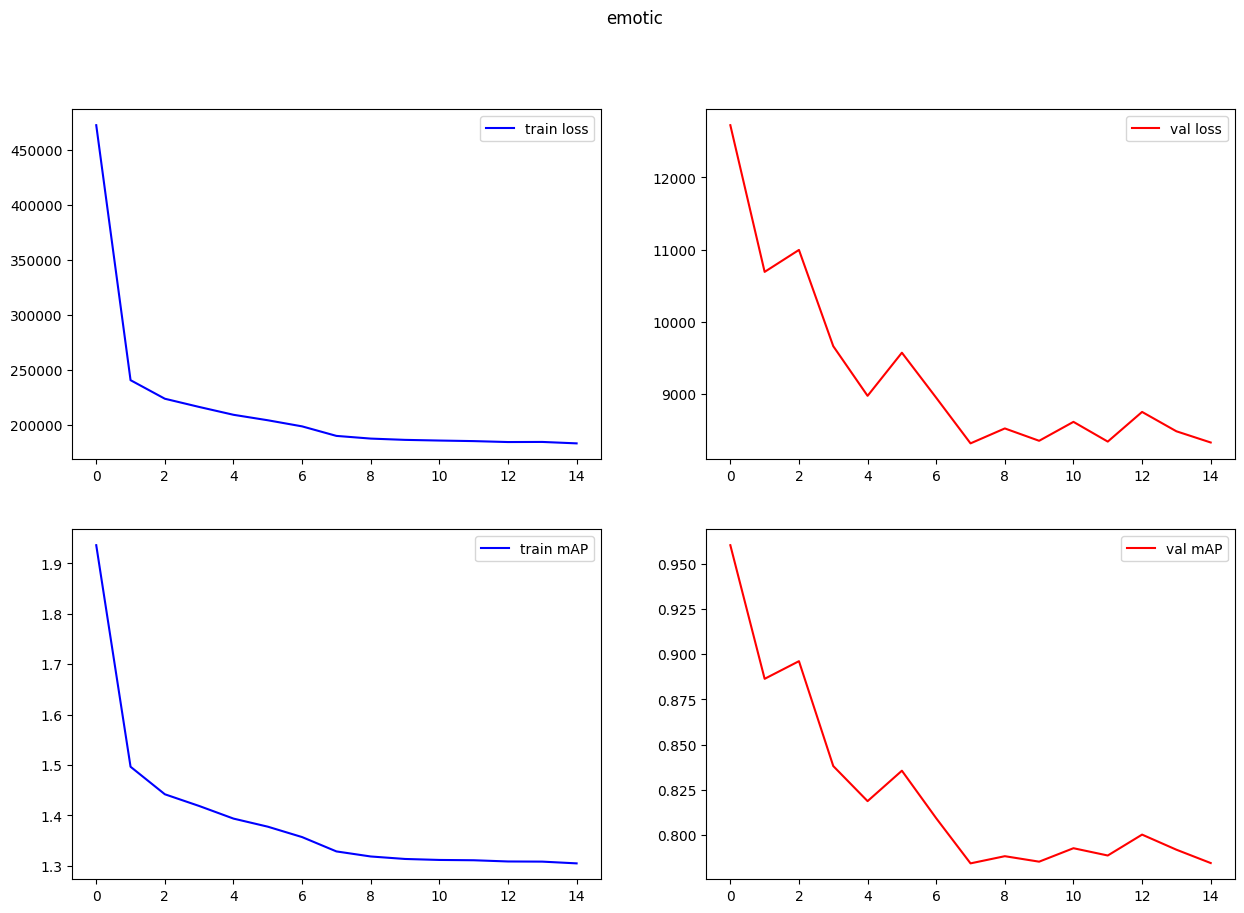

In [15]:
train_emotic(15, './models', opt, scheduler, [model_body, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [16]:
model_path = './models'
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_body.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
test_vad = test_data([model_body, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.91170645 0.98196846 0.9273119 ] (3,) 0.9403289
0.9403289
testing MAE=0.9403


# Train 2

---



## Resnet-50 (ImageNet)

In [ ]:
model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


## SwinT (Emotic)

In [19]:
model_body = torch.load("/content/drive/MyDrive/VA-prediction/models/SwinT_EMOTIC.pth", map_location=lambda storage, loc: storage)

In [20]:
batch_size = 26

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_body, train_cat, train_cont, \
                                  train_transform, body_norm)
val_dataset = Emotic_PreDataset(val_body,  val_cat, val_cont, \
                                test_transform, body_norm)
test_dataset = Emotic_PreDataset(test_body, test_cat, test_cont, \
                                 test_transform, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# VI. Prepare Model + Optimizer

In [21]:
emotic_model = Emotic(list(model_body.children())[-1].in_features)
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_body.parameters():
  param.requires_grad = False


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [23]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [24]:
def test_data(models, device, data_loader, num_images):
    model_body, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_body.to(device)
        emotic_model.to(device)
        model_body.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_body, labels_cat, labels_cont in iter(data_loader):
            images_body = images_body.to(device)

            pred_body = model_body(images_body)
            pred_cont = emotic_model(pred_body)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [25]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_body.to(device)

    emotic_model.train()
    model_body.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_body, labels_cat, labels_cont in iter(train_loader):
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_body = model_body(images_body)

      pred_cont = emotic_model(pred_body)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_body.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_body, labels_cat, labels_cont in iter(val_loader):
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_body = model_body(images_body)

        pred_cont = emotic_model(pred_body)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 431994.1886
vad [1.6781102 1.9589537 1.9665284] (3,) 1.8678641
epoch = 0 training MAE = 1.8679
epoch = 0 validation loss = 13234.1607
vad [0.84751683 1.1700715  0.8848913 ] (3,) 0.96749324
epoch = 0 val MAE= 0.9675
saving model at epoch e = 0
epoch = 1 training loss = 237266.5862
vad [1.2148441 1.6672987 1.5741692] (3,) 1.4854374
epoch = 1 training MAE = 1.4854
epoch = 1 validation loss = 11392.5562
vad [0.9640776  0.97312725 0.8176672 ] (3,) 0.9182907
epoch = 1 val MAE= 0.9183
saving model at epoch e = 1
epoch = 2 training loss = 222825.5322
vad [1.153921  1.6347566 1.5193951] (3,) 1.4360243
epoch = 2 training MAE = 1.4360
epoch = 2 validation loss = 9932.2431
vad [0.77061176 0.87530786 0.90113634] (3,) 0.84901863
epoch = 2 val MAE= 0.8490
saving model at epoch e = 2
epoch = 3 training loss = 211985.3563
vad [1.118191  1.6084261 1.4832485] (3,) 1.4032885
epoch = 3 training MAE = 1.4033
epoch = 3 validation loss = 11307.5578
vad [0.80220664 0.91083056 1.004833

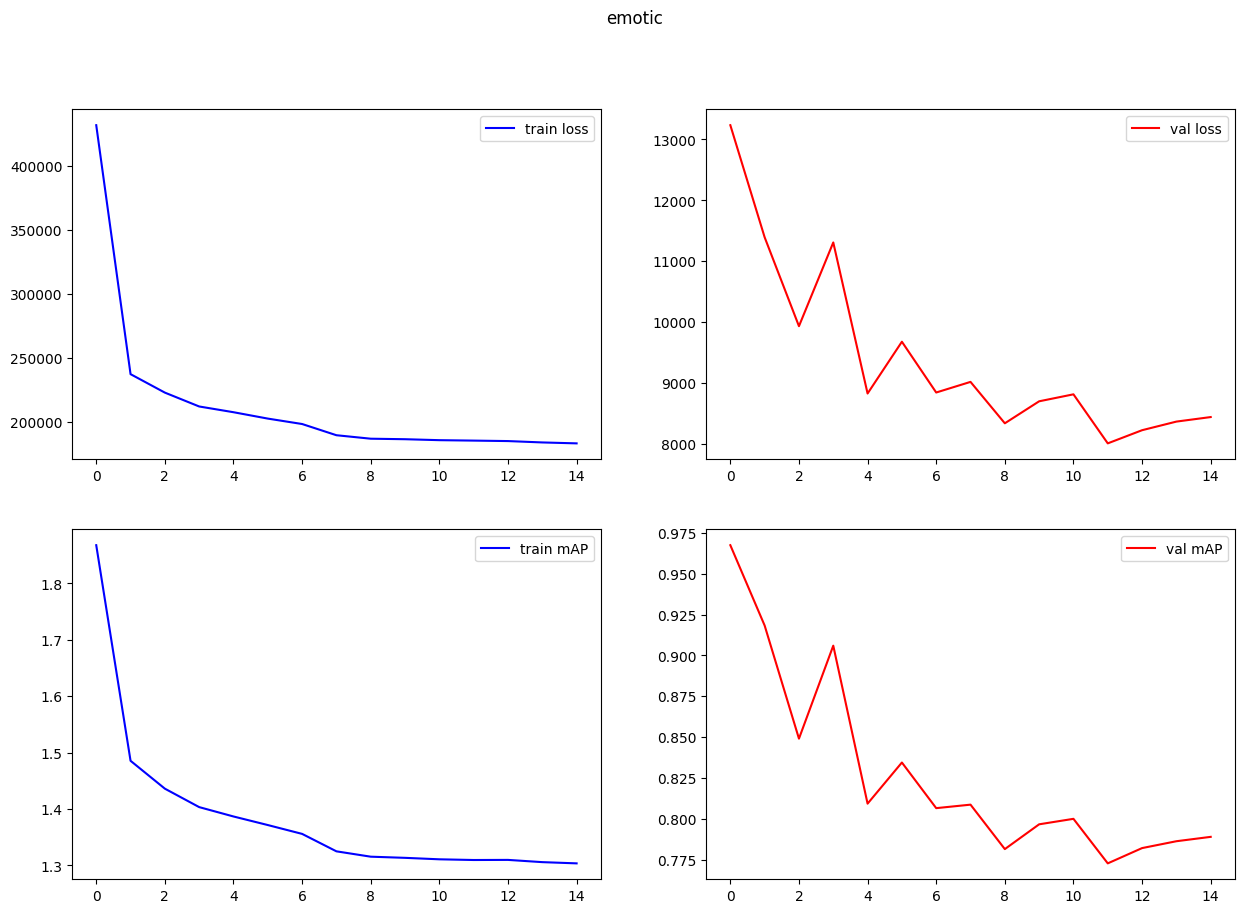

In [26]:
train_emotic(15, './models', opt, scheduler, [model_body, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [27]:
model_path = './models'
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_body.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
test_vad = test_data([model_body, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.9018473  0.98086375 0.9242119 ] (3,) 0.935641
0.935641
testing MAE=0.9356
